# |The ARX (AutoRegressive with eXogenous inputs)

In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [148]:
for line in lines:
    if line.strip():
        parts = line.split(': ')
        image_number, data = parts[0], parts[1]
        control_values, points, flags = eval(data)
        steering_angles.append(control_values[0])
        throttles.append(control_values[1])
        x_coords_list.append([point[0] if point else np.nan for point in points][::-1])  # Reverse the order here

df = pd.DataFrame(x_coords_list, columns=['x_farthest', 'x_middle2', 'x_middle1', 'x_closest'])
df['steering_angle'], df['throttle'] = steering_angles, throttles

for col in ['x_farthest', 'x_middle2', 'x_middle1', 'x_closest']:
    df[f'{col}_missing'] = df[col].isna().astype(int)

for col in ['x_farthest', 'x_middle2', 'x_middle1', 'x_closest']:
    df[f'next_{col}'] = df[col].shift(-1)

df = df[:-1]

df.dropna(inplace=True)
# Separate features and target variables
X = df.drop(columns=[f'next_{col}' for col in ['x_farthest', 'x_middle2', 'x_middle1', 'x_closest']] +
                   [f'{col}_missing' for col in ['x_farthest', 'x_middle2', 'x_middle1', 'x_closest']])
y_coords = df[[f'next_{col}' for col in ['x_farthest', 'x_middle2', 'x_middle1', 'x_closest']]]


In [149]:
n_lags = 1  # Number of lags to include
for col in ['x_farthest', 'x_middle1', 'x_middle2', 'x_closest', 'steering_angle', 'throttle']:
    for lag in range(1, n_lags + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Dropping rows with NaN values created by lagging
df.dropna(inplace=True)

# Define features and the actual targets which are the 'next' coordinates
features = [f'{col}_lag1' for col in ['x_farthest', 'x_middle1', 'x_middle2', 'x_closest', 'steering_angle', 'throttle']]
targets = ['next_x_farthest', 'next_x_middle1', 'next_x_middle2', 'next_x_closest']


In [150]:
targets

['next_x_farthest', 'next_x_middle1', 'next_x_middle2', 'next_x_closest']

In [151]:
features

['x_farthest_lag1',
 'x_middle1_lag1',
 'x_middle2_lag1',
 'x_closest_lag1',
 'steering_angle_lag1',
 'throttle_lag1']

In [152]:
df

,x_farthest,x_middle2,x_middle1,x_closest,steering_angle,throttle,x_farthest_missing,x_middle2_missing,x_middle1_missing,x_closest_missing,next_x_farthest,next_x_middle2,next_x_middle1,next_x_closest,x_farthest_lag1,x_middle1_lag1,x_middle2_lag1,x_closest_lag1,steering_angle_lag1,throttle_lag1
1,127,127.0,128.0,129.0,0.0,0.500000,0,0,0,0,127.0,128.0,129.0,129.0,128.0,129.0,128.0,126.0,0.000000,0.500000
2,127,128.0,129.0,129.0,0.0,0.500000,0,0,0,0,128.0,128.0,129.0,129.0,127.0,128.0,127.0,129.0,0.000000,0.500000
3,128,128.0,129.0,129.0,0.0,0.500000,0,0,0,0,127.0,128.0,128.0,129.0,127.0,129.0,128.0,129.0,0.000000,0.500000
4,127,128.0,128.0,129.0,0.0,0.500000,0,0,0,0,127.0,127.0,129.0,129.0,128.0,129.0,128.0,129.0,0.000000,0.500000
5,127,127.0,129.0,129.0,0.0,0.500000,0,0,0,0,127.0,127.0,128.0,128.0,127.0,128.0,128.0,129.0,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103439,81,76.0,74.0,69.0,0.0,-0.455594,0,0,0,0,72.0,70.0,68.0,62.0,165.0,123.0,146.0,100.0,0.314757,0.271050
103440,72,70.0,68.0,62.0,0.0,0.000000,0,0,0,0,64.0,63.0,64.0,62.0,81.0,74.0,76.0,69.0,0.000000,-0.455594
103441,64,63.0,64.0,62.0,0.0,-0.500000,0,0,0,0,57.0,56.0,60.0,55.0,72.0,68.0,70.0,62.0,0.000000,0.000000
103442,57,56.0,60.0,55.0,0.0,-0.500000,0,0,0,0,49.0,52.0,57.0,54.0,64.0,64.0,63.0,62.0,0.000000,-0.500000


In [153]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[targets], test_size=0.2, random_state=42)

results = {}
predictions = {}
mse_scores = []
r2_scores = []

for target in ['next_x_farthest', 'next_x_middle1', 'next_x_middle2', 'next_x_closest']:
    # Prepare the train and test datasets
    X_train_const = add_constant(X_train)
    X_test_const = add_constant(X_test)

    # Fit the model
    model = OLS(y_train[target], X_train_const)
    fitted_model = model.fit()
    results[target] = fitted_model.summary()

    # Predict
    y_pred = fitted_model.predict(X_test_const)
    predictions[target] = y_pred

    # Calculate and store MSE and R² for each target
    mse = mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

    # Output the MSE and R² Score for each target
    print(f'MSE for {target}: {mse}')
    print(f'R² Score for {target}: {r2}\n')

# Average the MSE and R² scores across all targets
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
print(f'Combined MSE: {average_mse}')
print(f'Combined R² Score: {average_r2}')


MSE for next_x_farthest: 197.96096560806555
R² Score for next_x_farthest: 0.9341284537254381

MSE for next_x_middle1: 155.23341625666313
R² Score for next_x_middle1: 0.9302602579484085

MSE for next_x_middle2: 171.85868363081806
R² Score for next_x_middle2: 0.9302157220014

MSE for next_x_closest: 159.4763759951527
R² Score for next_x_closest: 0.9337507442363867

Combined MSE: 171.13236037267487
Combined R² Score: 0.9320887944779083


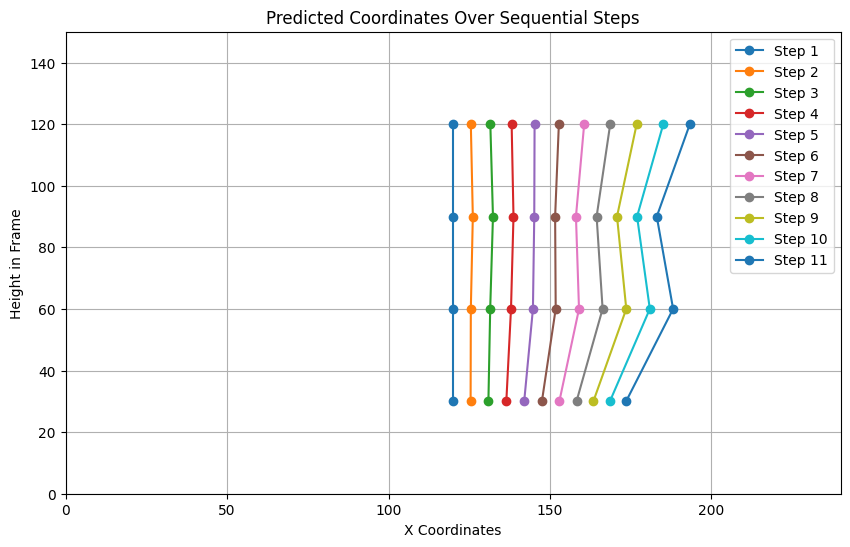

In [158]:
# Sequential Prediction Function
def make_prediction(current_features, fitted_models):
    X_const = add_constant(pd.DataFrame([current_features], columns=features), has_constant='add')
    predicted_coords = []
    for target in targets:
        predicted_coord = fitted_models[target].predict(X_const)[0]
        predicted_coords.append(predicted_coord)
    return np.array(predicted_coords)

# Initial features
initial_features = np.array([120, 120, 120, 120, 1, 0.5]) 

# Make sequential predictions
current_features = initial_features
predicted_trajectories = [initial_features[:4]]  # Store initial coordinates for visualization



for _ in range(10):
    fitted_models = {target: OLS(y_train[target], add_constant(X_train)).fit() for target in targets}
    predicted_coords = make_prediction(current_features, fitted_models)
    predicted_trajectories.append(predicted_coords)
    current_features = np.concatenate((predicted_coords, current_features[-2:]))

# Plotting

y_positions = [120, 90, 60, 30]
plt.figure(figsize=(10, 6))
for i, coords in enumerate(predicted_trajectories):
    plt.plot(coords, y_positions, marker='o', linestyle='-', label=f'Step {i+1}')

plt.title('Predicted Coordinates Over Sequential Steps')
plt.xlabel('X Coordinates')
plt.ylabel('Height in Frame')
plt.xlim(0, 240)
plt.ylim(0, 150)
plt.legend()
plt.grid(True)
plt.show()



# ARMAX (Autoregressive Moving Average with eXogenous inputs)

In [118]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

features = [f'{col}_lag1' for col in ['x_farthest', 'x_middle1', 'x_middle2', 'x_closest', 'steering_angle', 'throttle']]
targets = ['next_x_farthest', 'next_x_middle1', 'next_x_middle2', 'next_x_closest']
X_train, X_test, y_train, y_test = train_test_split(df[features], df[targets], test_size=0.2, random_state=42)

# Initial ARX model to estimate errors
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

errors = {}
for target in targets:
    X_tr_const = add_constant(X_train)
    model = OLS(y_train[target], X_tr_const).fit()
    predictions = model.predict(X_tr_const)
    errors[target] = y_train[target] - predictions  # Compute residuals (initial error estimates)

# Fit ARMAX Model 
armax_results = {}
for target in targets:
    model = SARIMAX(y_train[target], exog=X_train[features], order=(1,0,1), seasonal_order=(0,0,0,0), 
                    enforce_stationarity=False, enforce_invertibility=False, measurement_error=True)
    fitted_model = model.fit(disp=False)
    armax_results[target] = fitted_model

    print(f"ARMAX Model Summary for {target}:")
    print(fitted_model.summary())

    # Predict and evaluate
    y_pred = fitted_model.get_forecast(steps=len(X_test), exog=X_test[features]).predicted_mean
    mse = mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    print(f'MSE for {target}: {mse}')
    print(f'R^2 Score for {target}: {r2}\n')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMAX Model Summary for next_x_farthest:
                               SARIMAX Results                                
Dep. Variable:        next_x_farthest   No. Observations:                26948
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -109386.732
Date:                Fri, 05 Jul 2024   AIC                         218793.464
Time:                        17:39:04   BIC                         218875.480
Sample:                             0   HQIC                        218819.915
                              - 26948                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
x_farthest_lag1           0.3006      0.006     51.927      0.000       0.289       0.312
x_middle1_lag1            0.0951      0.009     10.187   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be 

ARMAX Model Summary for next_x_middle1:
                               SARIMAX Results                                
Dep. Variable:         next_x_middle1   No. Observations:                26948
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -106150.338
Date:                Fri, 05 Jul 2024   AIC                         212320.677
Time:                        17:39:21   BIC                         212402.693
Sample:                             0   HQIC                        212347.128
                              - 26948                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
x_farthest_lag1          -0.0727      0.008     -9.549      0.000      -0.088      -0.058
x_middle1_lag1            0.8800      0.008    111.873    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be 

ARMAX Model Summary for next_x_middle2:
                               SARIMAX Results                                
Dep. Variable:         next_x_middle2   No. Observations:                26948
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -107831.405
Date:                Fri, 05 Jul 2024   AIC                         215682.809
Time:                        17:39:26   BIC                         215764.825
Sample:                             0   HQIC                        215709.260
                              - 26948                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
x_farthest_lag1          -0.2890      0.005    -56.453      0.000      -0.299      -0.279
x_middle1_lag1            0.2965      0.007     40.093    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be 

ARMAX Model Summary for next_x_closest:
                               SARIMAX Results                                
Dep. Variable:         next_x_closest   No. Observations:                26948
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -106225.847
Date:                Fri, 05 Jul 2024   AIC                         212471.694
Time:                        17:39:34   BIC                         212553.710
Sample:                             0   HQIC                        212498.145
                              - 26948                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
x_farthest_lag1           0.2186      0.008     27.456      0.000       0.203       0.234
x_middle1_lag1            0.1030      0.010     10.467    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
